In [852]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools
import warnings
warnings.filterwarnings("ignore")


In [853]:
df = pd.read_csv("car_registrations_tedata.csv")
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)

y = df["Indonesia Total Car Sales"].asfreq("MS")

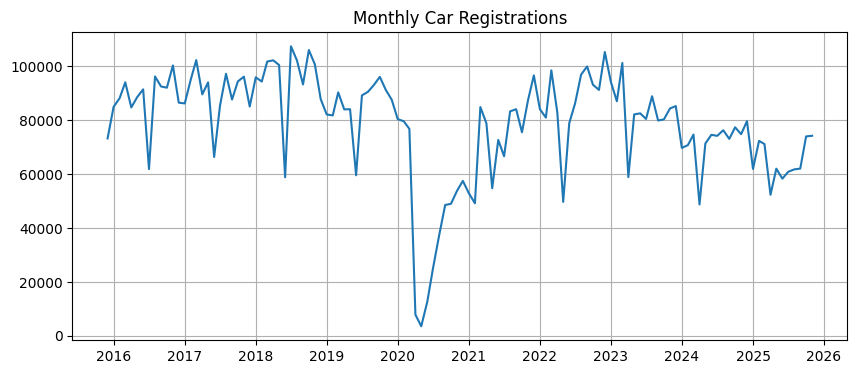

In [854]:
plt.figure(figsize=(10,4))
plt.plot(y)
plt.title("Monthly Car Registrations")
plt.grid(True)
plt.show()

In [855]:
def adf_test(series):
    result = adfuller(series.dropna())
    print("ADF Statistic :", result[0])
    print("p-value       :", result[1])

adf_test(y)


ADF Statistic : -2.302120866857858
p-value       : 0.17128486212914218


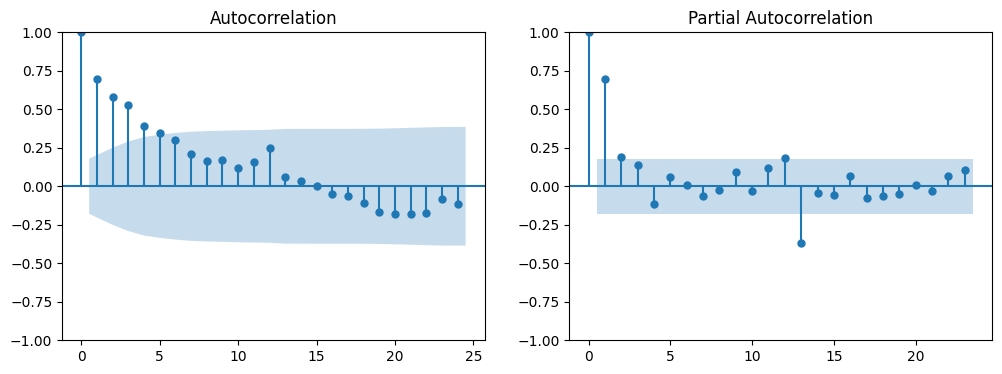

In [856]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(y, lags=24, ax=ax[0])
plot_pacf(y, lags=23, ax=ax[1])
plt.show()

In [857]:
y_diff = y.diff().dropna()
adf_test(y_diff)


ADF Statistic : -3.2358885675089435
p-value       : 0.01799905096223132


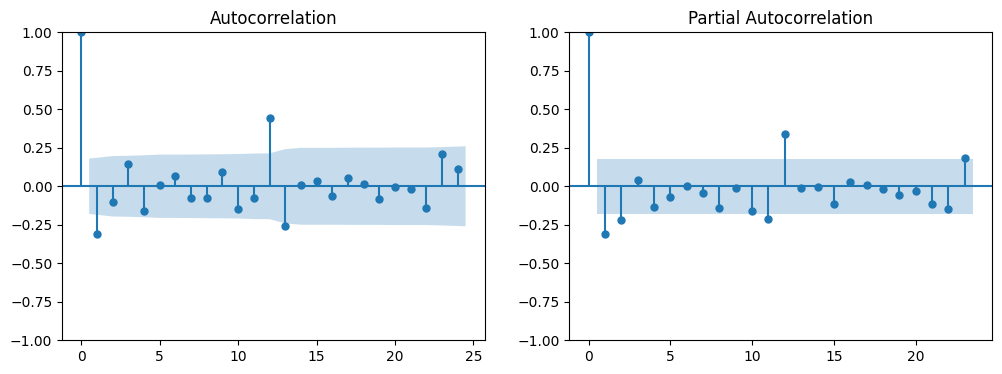

In [858]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(y_diff, lags=24, ax=ax[0])
plot_pacf(y_diff, lags=23, ax=ax[1])
plt.show()

In [859]:
y_seasonal_diff = y_diff.diff(12).dropna()
adf_test(y_seasonal_diff)


ADF Statistic : -13.007466708715901
p-value       : 2.6095971970405493e-24


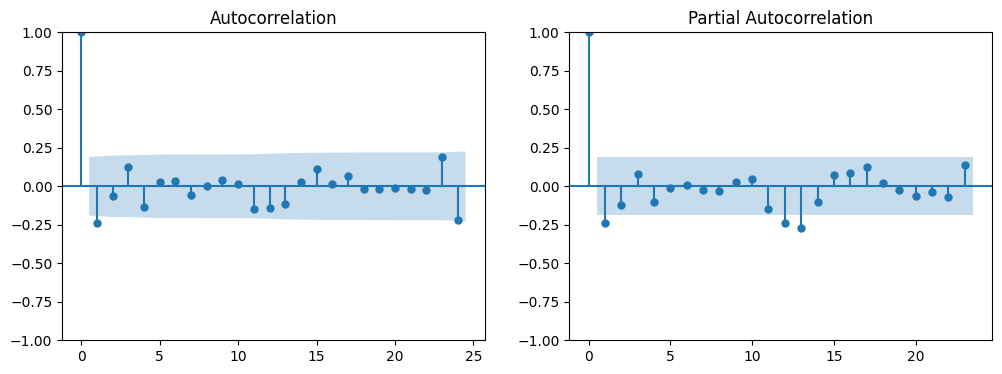

In [860]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(y_seasonal_diff, lags=24, ax=ax[0])
plot_pacf(y_seasonal_diff, lags=23, ax=ax[1])
plt.show()


In [861]:
train = y.iloc[:-12]
test  = y.iloc[-12:]

p = [0,1,2]
d = [1]
q = [0,1,2]

P = [0,1]
D = [0,1]
Q = [0,1]

s = 12

results = []

for param in itertools.product(p,d,q):
    for param_seasonal in itertools.product(P,D,Q):
        try:
            model = SARIMAX(
                train,
                order=param,
                seasonal_order=(param_seasonal[0],
                                param_seasonal[1],
                                param_seasonal[2],
                                s),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            res = model.fit(disp=False)
            forecast = res.forecast(steps=len(test))
            rmse = np.sqrt(mean_squared_error(test, forecast))

            results.append({
                "order": param,
                "seasonal": (param_seasonal[0],
                             param_seasonal[1],
                             param_seasonal[2],
                             s),
                "AIC": res.aic,
                "RMSE": rmse
            })
        except:
            continue

results_df = pd.DataFrame(results).sort_values("RMSE")
results_df.head()


,order,seasonal,AIC,RMSE
3,"(0, 1, 0)","(0, 1, 1, 12)",1822.756352,5834.595909
30,"(1, 1, 0)","(1, 1, 0, 12)",1825.140965,6068.161825
38,"(1, 1, 1)","(1, 1, 0, 12)",1826.239696,6080.108602
14,"(0, 1, 1)","(1, 1, 0, 12)",1845.558228,6082.532029
22,"(0, 1, 2)","(1, 1, 0, 12)",1847.121832,6082.635868


In [862]:
best = results_df.iloc[0]

sarima_model = SARIMAX(
    train,
    order=best["order"],
    seasonal_order=best["seasonal"],
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

print(sarima_model.summary())

resid = sarima_model.resid.dropna()

lb = acorr_ljungbox(resid, lags=[12], return_df=True)
print(lb)

                                      SARIMAX Results                                       
Dep. Variable:            Indonesia Total Car Sales   No. Observations:                  108
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -909.378
Date:                              Sun, 04 Jan 2026   AIC                           1822.756
Time:                                      18:53:17   BIC                           1827.570
Sample:                                  12-01-2015   HQIC                          1824.689
                                       - 11-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.6023      0.081     -7.469      0.000      -0.760      -0.444
sigma2      2.956e+

In [863]:
forecast = sarima_model.forecast(steps=len(test))

rmse = np.sqrt(mean_squared_error(test, forecast))
mae  = mean_absolute_error(test, forecast)
mape = np.mean(np.abs((test - forecast) / test)) * 100

print("RMSE :", rmse)
print("MAE  :", mae)
print("MAPE :", mape)


RMSE : 5834.595908534881
MAE  : 5102.494490456956
MAPE : 7.981197501382538


In [864]:
resid_train = sarima_model.resid.dropna()

lags = [1, 2, 12, 13, 14]

def make_lagged_residuals(series, lags):
    X, y = [], []
    for i in range(max(lags), len(series)):
        X.append([series.iloc[i - l] for l in lags])
        y.append(series.iloc[i])
    return np.array(X), np.array(y)

X_nn, y_nn = make_lagged_residuals(resid_train, lags)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_nn_scaled = scaler.fit_transform(X_nn)

from sklearn.neural_network import MLPRegressor

nn_model = MLPRegressor(
    hidden_layer_sizes=(10,10),
    activation="relu",
    solver="adam",
    max_iter=5000,
    random_state=42
)

nn_model.fit(X_nn_scaled, y_nn)


,loss,'squared_error'
,hidden_layer_sizes,"(10, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,5000
,shuffle,True


In [865]:
# Prediksi residual NN (in-sample)
nn_resid_pred = nn_model.predict(X_nn_scaled)

# Samakan index (karena lag)
nn_index = resid_train.index[max(lags):]
nn_resid_pred = pd.Series(nn_resid_pred, index=nn_index)

# SARIMA fitted (sesuai index NN)
sarima_fitted = sarima_model.fittedvalues.loc[nn_index]

# Hybrid fitted
hybrid_fitted = sarima_fitted + nn_resid_pred

# Data aktual (sesuai index)
y_actual = y.loc[nn_index]

# Residual hybrid
hybrid_resid = y_actual - hybrid_fitted

from statsmodels.stats.diagnostic import acorr_ljungbox

lb_hybrid = acorr_ljungbox(hybrid_resid, lags=[12], return_df=True)
print(lb_hybrid)


     lb_stat  lb_pvalue
12  8.871901   0.713831


In [866]:
def nn_residual_forecast(nn_model, scaler, resid_train, lags, n_steps):
    preds = []
    history = list(resid_train)

    for _ in range(n_steps):
        X_input = np.array([[history[-l] for l in lags]])
        X_input = scaler.transform(X_input)

        pred = nn_model.predict(X_input)[0]
        preds.append(pred)
        history.append(pred)

    return np.array(preds)


In [867]:
resid_nn_forecast = nn_residual_forecast(
    nn_model,
    scaler,
    resid_train,
    lags,
    len(test)
)


In [868]:
hybrid_forecast = forecast.values + resid_nn_forecast


In [869]:
rmse_h = np.sqrt(mean_squared_error(test, hybrid_forecast))
mae_h  = mean_absolute_error(test, hybrid_forecast)
mape_h = np.mean(np.abs((test - hybrid_forecast) / test)) * 100

print("=== SARIMA ONLY ===")
print("RMSE :", rmse)
print("MAE  :", mae)
print("MAPE :", mape)

print("\n=== HYBRID SARIMA + NN ===")
print("RMSE :", rmse_h)
print("MAE  :", mae_h)
print("MAPE :", mape_h)


=== SARIMA ONLY ===
RMSE : 5834.595908534881
MAE  : 5102.494490456956
MAPE : 7.981197501382538

=== HYBRID SARIMA + NN ===
RMSE : 4631.33880383718
MAE  : 3883.8340824901006
MAPE : 5.870082559893344


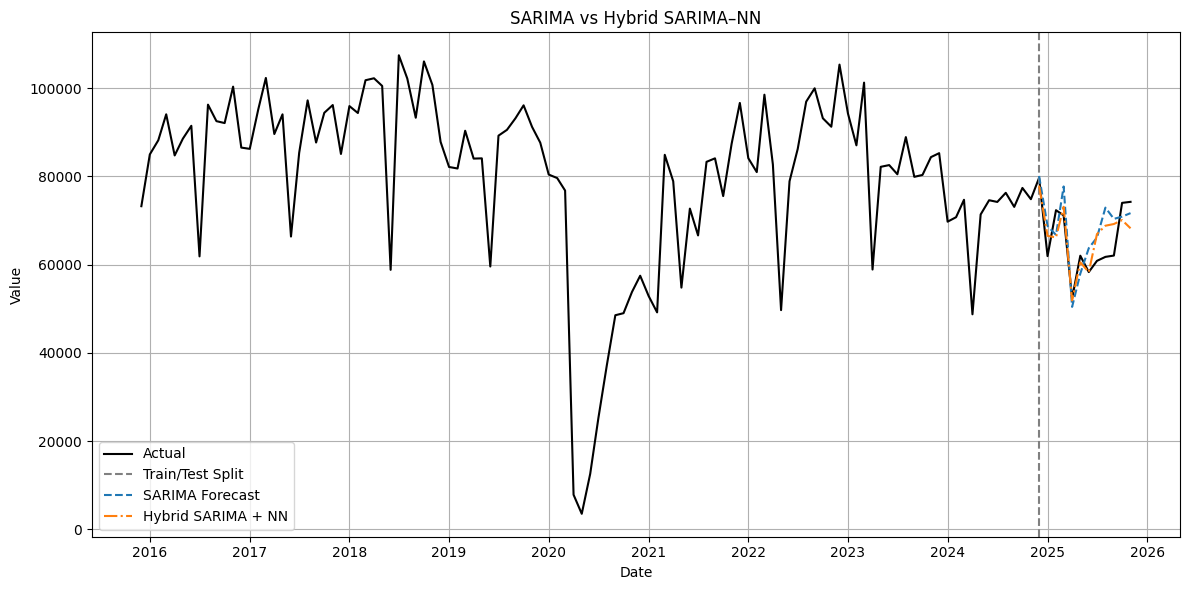

In [870]:
plt.figure(figsize=(12,6))

plt.plot(y.index, y.values, label="Actual", color="black")
plt.axvline(test.index[0], color="gray", linestyle="--", label="Train/Test Split")

plt.plot(test.index, forecast.values, "--", label="SARIMA Forecast")
plt.plot(test.index, hybrid_forecast, "-.", label="Hybrid SARIMA + NN")

plt.title("SARIMA vs Hybrid SARIMA–NN")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


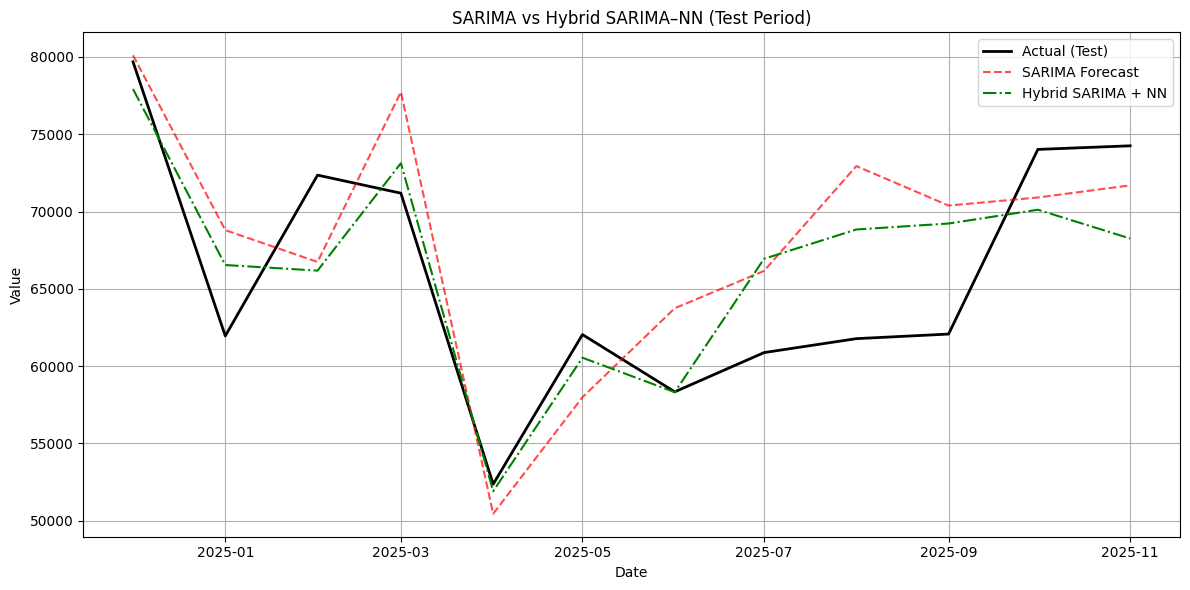

In [871]:
plt.figure(figsize=(12,6))

# Actual (test only)
plt.plot(
    test.index,
    test.values,
    label="Actual (Test)",
    color="black",
    linewidth=2
)

# SARIMA Forecast (test)
plt.plot(
    test.index,
    forecast.values,
    "--",
    label="SARIMA Forecast",
    color="red",
    alpha=0.7
)

# Hybrid Forecast (test)
plt.plot(
    test.index,
    hybrid_forecast,
    "-.",
    label="Hybrid SARIMA + NN",
    color="green"
)

plt.title("SARIMA vs Hybrid SARIMA–NN (Test Period)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


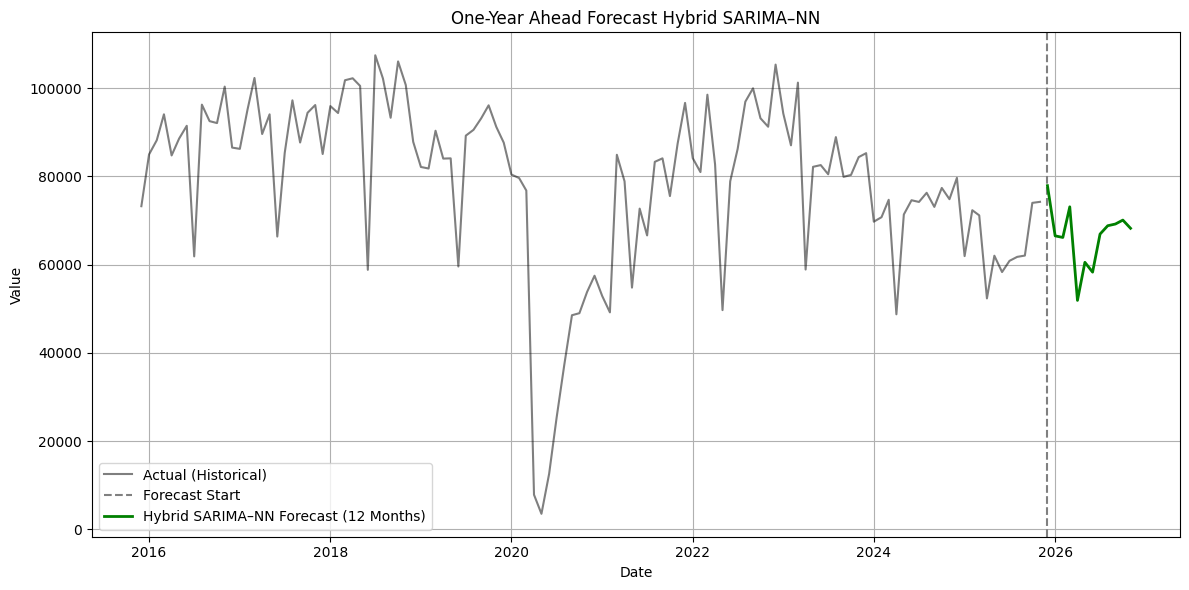

In [876]:
n_forecast = 12

future_index = pd.date_range(
    start=y.index[-1] + pd.offsets.MonthBegin(1),
    periods=n_forecast,
    freq="MS"
)

hybrid_forecast = pd.Series(
    hybrid_forecast,
    index=future_index
)

plt.figure(figsize=(12,6))

# Data historis (konteks)
plt.plot(
    y.index,
    y.values,
    label="Actual (Historical)",
    color="black",
    alpha=0.5
)

# Garis awal forecast
plt.axvline(
    future_index[0],
    color="gray",
    linestyle="--",
    label="Forecast Start"
)

# Hybrid Forecast
plt.plot(
    future_index,
    hybrid_forecast.values,
    label="Hybrid SARIMA–NN Forecast (12 Months)",
    color="green",
    linewidth=2
)

plt.title("One-Year Ahead Forecast Hybrid SARIMA–NN")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [873]:
n_forecast = 60  # 5 tahun

future_index = pd.date_range(
    start=y.index[-1] + pd.offsets.MonthBegin(1),
    periods=n_forecast,
    freq="MS"
)

sarima_5y = sarima_model.get_forecast(steps=n_forecast).predicted_mean
sarima_5y.index = future_index

# resid_train: residual SARIMA pada data train/full (sudah kamu punya)
# lags: [1, 2, 12, 13, 14]
# nn_model, scaler: sudah di-fit

def hybrid_forecast_5y(sarima_forecast, nn_model, scaler, resid_train, lags):
    preds = []
    current_res = list(resid_train)

    for i in range(len(sarima_forecast)):
        nn_input = np.array([[current_res[-l] for l in lags]])
        nn_input_scaled = scaler.transform(nn_input)

        nn_res_pred = nn_model.predict(nn_input_scaled)[0]
        y_pred = sarima_forecast.iloc[i] + nn_res_pred

        preds.append(y_pred)
        current_res.append(nn_res_pred)

    return pd.Series(preds, index=sarima_forecast.index)

hybrid_5y = hybrid_forecast_5y(
    sarima_5y,
    nn_model,
    scaler,
    resid_train,
    lags
)



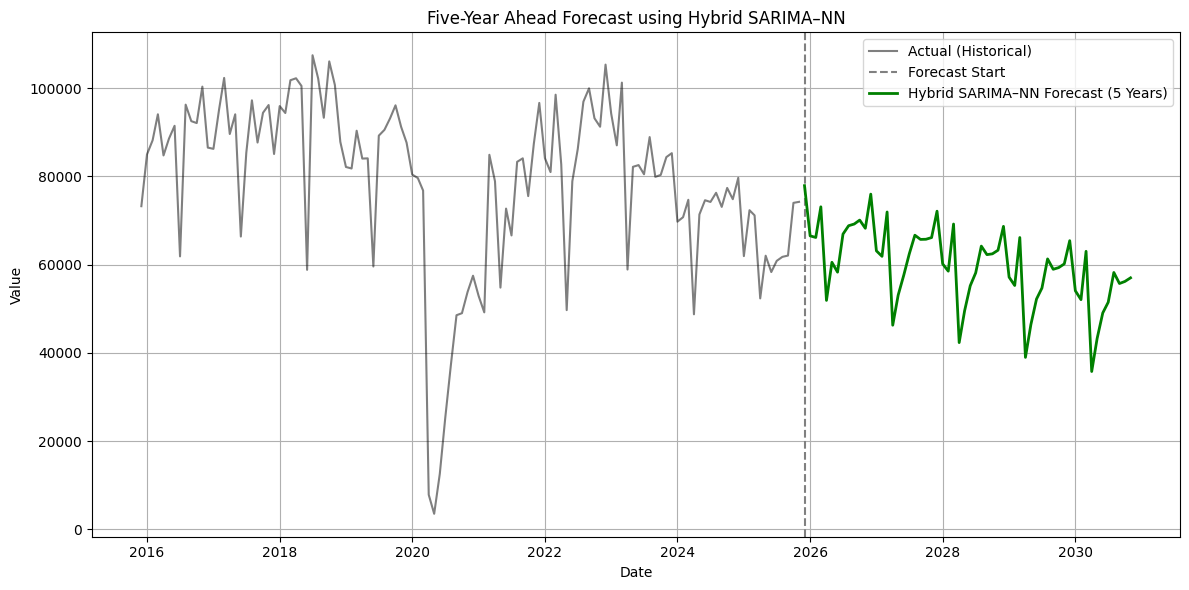

In [874]:
plt.figure(figsize=(12,6))

# Data historis (konteks)
plt.plot(
    y.index,
    y.values,
    label="Actual (Historical)",
    color="black",
    alpha=0.5
)

# Garis awal forecast
plt.axvline(
    future_index[0],
    color="gray",
    linestyle="--",
    label="Forecast Start"
)

# Hybrid Forecast 5 Tahun
plt.plot(
    hybrid_5y.index,
    hybrid_5y.values,
    label="Hybrid SARIMA–NN Forecast (5 Years)",
    color="green",
    linewidth=2
)

plt.title("Five-Year Ahead Forecast using Hybrid SARIMA–NN")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


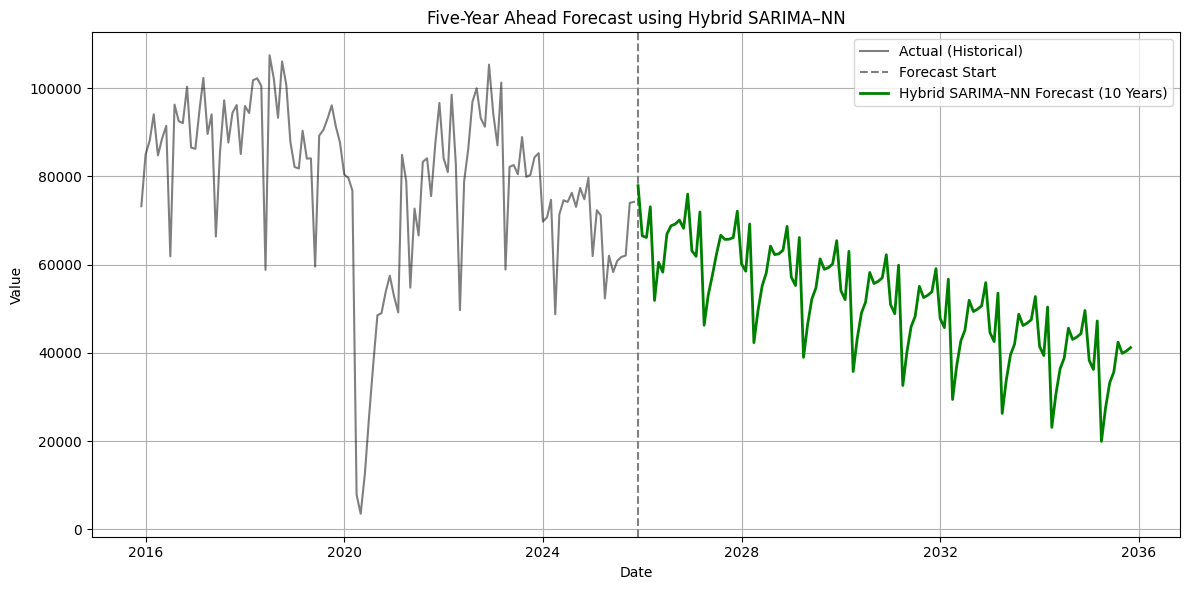

In [875]:
n_forecast = 120  # 10 tahun

future_index = pd.date_range(
    start=y.index[-1] + pd.offsets.MonthBegin(1),
    periods=n_forecast,
    freq="MS"
)

sarima_10y = sarima_model.get_forecast(steps=n_forecast).predicted_mean
sarima_10y.index = future_index

# resid_train: residual SARIMA pada data train/full (sudah kamu punya)
# lags: [1, 2, 12, 13, 14]
# nn_model, scaler: sudah di-fit

def hybrid_forecast_10y(sarima_forecast, nn_model, scaler, resid_train, lags):
    preds = []
    current_res = list(resid_train)

    for i in range(len(sarima_forecast)):
        nn_input = np.array([[current_res[-l] for l in lags]])
        nn_input_scaled = scaler.transform(nn_input)

        nn_res_pred = nn_model.predict(nn_input_scaled)[0]
        y_pred = sarima_forecast.iloc[i] + nn_res_pred

        preds.append(y_pred)
        current_res.append(nn_res_pred)

    return pd.Series(preds, index=sarima_forecast.index)

hybrid_10y = hybrid_forecast_10y(
    sarima_10y,
    nn_model,
    scaler,
    resid_train,
    lags
)

plt.figure(figsize=(12,6))

# Data historis (konteks)
plt.plot(
    y.index,
    y.values,
    label="Actual (Historical)",
    color="black",
    alpha=0.5
)

# Garis awal forecast
plt.axvline(
    future_index[0],
    color="gray",
    linestyle="--",
    label="Forecast Start"
)

# Hybrid Forecast 10 Tahun
plt.plot(
    hybrid_10y.index,
    hybrid_10y.values,
    label="Hybrid SARIMA–NN Forecast (10 Years)",
    color="green",
    linewidth=2
)

plt.title("Five-Year Ahead Forecast using Hybrid SARIMA–NN")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
